# Imports 

In [1]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

from accelerate import Accelerator

#### Model and processor

In [2]:
device = 'cuda'

In [3]:
accelerator = Accelerator()

In [4]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

C:\Users\pierr\anaconda3\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Testing the model

In [54]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open('birb.jpg')

In [60]:
inputs = processor(text=["a photo of a vulture","a photo of a pipit", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

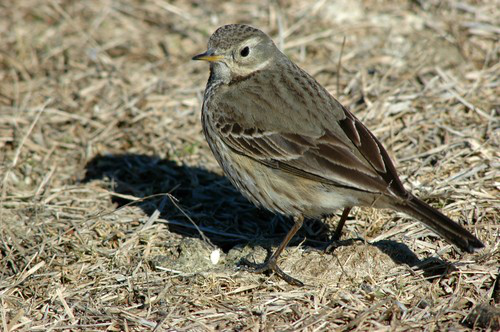

In [61]:
image

In [62]:
outputs = model(**inputs.to(device))
logits_per_image = outputs.logits_per_image

In [63]:
probs = logits_per_image.softmax(dim=1)

In [64]:
probs

tensor([[3.5743e-09, 1.0000e+00, 1.6385e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

It's a cat !

# Loading data

In [11]:
label_text_file_adress = 'data/CUB_200_2011/classes.txt'

In [12]:
label_text_file = open(label_text_file_adress, "r")

In [13]:
import re

In [14]:
for line in label_text_file:
  print(re.split(r"\.",line)[-1])

Black_footed_Albatross

Laysan_Albatross

Sooty_Albatross

Groove_billed_Ani

Crested_Auklet

Least_Auklet

Parakeet_Auklet

Rhinoceros_Auklet

Brewer_Blackbird

Red_winged_Blackbird

Rusty_Blackbird

Yellow_headed_Blackbird

Bobolink

Indigo_Bunting

Lazuli_Bunting

Painted_Bunting

Cardinal

Spotted_Catbird

Gray_Catbird

Yellow_breasted_Chat

Eastern_Towhee

Chuck_will_Widow

Brandt_Cormorant

Red_faced_Cormorant

Pelagic_Cormorant

Bronzed_Cowbird

Shiny_Cowbird

Brown_Creeper

American_Crow

Fish_Crow

Black_billed_Cuckoo

Mangrove_Cuckoo

Yellow_billed_Cuckoo

Gray_crowned_Rosy_Finch

Purple_Finch

Northern_Flicker

Acadian_Flycatcher

Great_Crested_Flycatcher

Least_Flycatcher

Olive_sided_Flycatcher

Scissor_tailed_Flycatcher

Vermilion_Flycatcher

Yellow_bellied_Flycatcher

Frigatebird

Northern_Fulmar

Gadwall

American_Goldfinch

European_Goldfinch

Boat_tailed_Grackle

Eared_Grebe

Horned_Grebe

Pied_billed_Grebe

Western_Grebe

Blue_Grosbeak

Evening_Grosbeak

Pine_Grosbea

In [15]:
def get_classes(label_text_file_adress):
    label_text_file = open(label_text_file_adress, "r")
    classes = []
    for line in label_text_file:
        text = re.split(r"\.",line)[-1]
        text = re.split(r"_", text)
        label = ""
        for word in text: 
            label += word
            label += ' '
        classes.append(label.strip())
    return classes

In [16]:
classes = get_classes(label_text_file_adress)

In [17]:
print(classes)

['Black footed Albatross', 'Laysan Albatross', 'Sooty Albatross', 'Groove billed Ani', 'Crested Auklet', 'Least Auklet', 'Parakeet Auklet', 'Rhinoceros Auklet', 'Brewer Blackbird', 'Red winged Blackbird', 'Rusty Blackbird', 'Yellow headed Blackbird', 'Bobolink', 'Indigo Bunting', 'Lazuli Bunting', 'Painted Bunting', 'Cardinal', 'Spotted Catbird', 'Gray Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Brandt Cormorant', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'Brown Creeper', 'American Crow', 'Fish Crow', 'Black billed Cuckoo', 'Mangrove Cuckoo', 'Yellow billed Cuckoo', 'Gray crowned Rosy Finch', 'Purple Finch', 'Northern Flicker', 'Acadian Flycatcher', 'Great Crested Flycatcher', 'Least Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Vermilion Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Northern Fulmar', 'Gadwall', 'American Goldfinch', 'European Goldfinch', 'Boat tailed Grackle', 'Eared 

## Creating Dataframe

In [18]:
import pandas as pd
import os 
import numpy as np

In [19]:
def create_dataframe(folder):
    df = pd.DataFrame({'file':[], 'label': []})
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]
    for i, subfolder in enumerate(subfolders):
        files = np.array([os.path.join(subfolder, f) for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))])
        labels = [int(i+1) for k in range(len(files))]
        df2 = pd.DataFrame({'file':files, 'label': labels})
        df = pd.concat([df, df2]).reset_index(drop = True)
    return df

In [20]:
folder = 'data\\CUB_200_2011\\images'
df = create_dataframe(folder)

In [21]:
df['file'][0]

'data\\CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg'

In [22]:
df.to_csv('birds.csv', index=False)

# Defining a dataset

In [23]:
import torch
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [24]:
class BirdsDataset(Dataset):
    """Birds dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.birds_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.birds_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.birds_df.iloc[idx, 0])
        image = io.imread(img_name)
        labels = self.birds_df.iloc[idx, 1:]
        labels = np.array([labels], dtype=float)
        sample = {'image': image, 'label': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [25]:
csv_file = 'C:\\Users\\pierr\\Documents\\INF649-Computer_Vision\\project\\data\\CUB_200_2011\\birds.csv'
root_dir = 'C:\\Users\\pierr\\Documents\\INF649-Computer_Vision\\project'

birds_dataset = BirdsDataset(csv_file=csv_file,
                                    root_dir=root_dir)

0 (223, 320, 3) (1, 1)
1 (347, 500, 3) (1, 1)
2 (375, 500, 3) (1, 1)
3 (335, 500, 3) (1, 1)


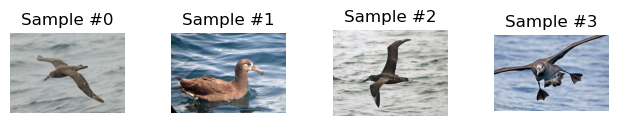

In [26]:
fig = plt.figure()

for i, sample in enumerate(birds_dataset):
    print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

In [27]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image': img, 'label': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

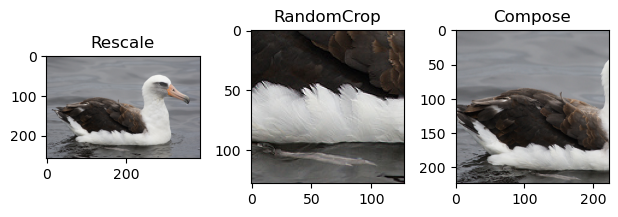

In [28]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = birds_dataset[90]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

In [29]:
transformed_dataset = BirdsDataset(csv_file=csv_file,
                                           root_dir=root_dir,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# Better method

In [30]:
from torchvision import transforms, datasets

In [70]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((128, 128))
    ])
birb_dataset = datasets.ImageFolder(root='C:\\Users\\pierr\\Documents\\INF649-Computer_Vision\\project\\data\\CUB_200_2011\\images',
                                           transform=data_transform)

# Batch visualization

In [32]:
def show_image(image, label, classes):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(classes[int(label)-1])

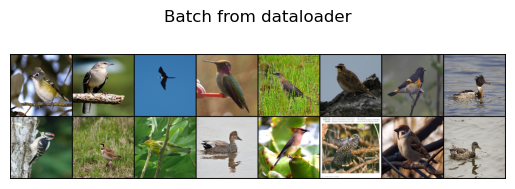

In [72]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_images_batch(sample_batched):
    """Show image for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    #for i in range(batch_size):
    #    row = i % 2 
    #    col = i % 4
    #    plt.text(col * (im_size + 2) + 2, row * (im_size +30)-4, np.array(classes)[labels_batch[i, :, 0].numpy().astype(int)-1][0], c = 'k')

    plt.title('Batch from dataloader', y=1.2)

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(birb_dataloader):

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Classification attempt

We have a processor for text and image latent vectors generation and a model for classification. We want to get the accuracy of the 'vanilla' model, meaning using only classes names as prompts

In [71]:
birb_dataloader = torch.utils.data.DataLoader(birb_dataset,
                                             batch_size=16, shuffle=True,
                                             num_workers=4)

In [116]:
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image

In [36]:
def create_queries(classes):
    queries = []
    for c in classes:
        queries.append(f'A photo of a {c}, a type of bird')
    return queries

In [102]:
queries = create_queries(classes)

In [103]:
queries.append('a photo of a car')
queries.append('a photo of a dog')
queries.append('a photo of a plane')

In [104]:
queries

['A photo of a Black footed Albatross, a type of bird',
 'A photo of a Laysan Albatross, a type of bird',
 'A photo of a Sooty Albatross, a type of bird',
 'A photo of a Groove billed Ani, a type of bird',
 'A photo of a Crested Auklet, a type of bird',
 'A photo of a Least Auklet, a type of bird',
 'A photo of a Parakeet Auklet, a type of bird',
 'A photo of a Rhinoceros Auklet, a type of bird',
 'A photo of a Brewer Blackbird, a type of bird',
 'A photo of a Red winged Blackbird, a type of bird',
 'A photo of a Rusty Blackbird, a type of bird',
 'A photo of a Yellow headed Blackbird, a type of bird',
 'A photo of a Bobolink, a type of bird',
 'A photo of a Indigo Bunting, a type of bird',
 'A photo of a Lazuli Bunting, a type of bird',
 'A photo of a Painted Bunting, a type of bird',
 'A photo of a Cardinal, a type of bird',
 'A photo of a Spotted Catbird, a type of bird',
 'A photo of a Gray Catbird, a type of bird',
 'A photo of a Yellow breasted Chat, a type of bird',
 'A photo of

Ok en fait il faut que tu processes les images et le texte séparément et que tu calcules la similarité cosinus entre les deux une fois que c'est fait 

In [106]:
true_labels = []
scores=[]

#Getting queries embeddings
################################################################
queries_tokens = processor(
    text=queries,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

queries_emb = model.get_text_features(**queries_tokens)
# detach from pytorch gradient computation
queries_emb = queries_emb.detach().cpu().numpy()
# normalization
queries_emb = queries_emb / np.linalg.norm(queries_emb, axis=0)
################################################################


#Calculating image embedding and cosine similarity between both embedding types
################################################################
for i_batch, sample_batched in enumerate(tqdm(birb_dataloader)):
    
    images_batch, labels_batch = \
            sample_batched[0], sample_batched[1]
    images_batch = [to_pil_image(image) for image in images_batch]
    with torch.no_grad():
        img_tokens = processor(text=None, images=images_batch, return_tensors="pt")['pixel_values'].to(device)
        img_emb = model.get_image_features(img_tokens)
        img_emb = img_emb.detach().cpu().numpy()
        #outputs = model(**inputs.to(device))
        score = np.dot(img_emb, queries_emb.T)
    
    scores.append(score)
    true_labels.append(labels_batch)
    
true_labels = torch.cat(true_labels)
#scores = torch.cat(scores)

100%|██████████| 737/737 [03:38<00:00,  3.37it/s]


In [107]:
scores = np.concatenate(scores)

In [108]:
scores.shape

(11788, 203)

In [109]:
scores.argmax(axis=1)

array([ 71,  19,  38, ..., 174,  22,  21], dtype=int64)

In [117]:
F1Score = multiclass_f1_score(torch.tensor(scores),true_labels)
acc = multiclass_accuracy(torch.tensor(scores),true_labels)

In [118]:
print(f'F1 score : {F1Score}')
print(f'Accuracy : {acc}')

F1 score : 0.352477103471756
Accuracy : 0.352477103471756


In [ ]:
classes[101]